In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as f
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

from torchsummary import summary

import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")

In [2]:
num_per_class = 1000
image_size = 91

x = np.linspace(-4, 4, image_size)
x, y = np.meshgrid(x, x)

widths = [1.8, 2.4]

images = torch.zeros(2*num_per_class, 1, image_size, image_size)
labels = torch.zeros(2*num_per_class)

for i in range(2*num_per_class):
    random_offset = 2*np.random.randn(2)
    gaussian = np.exp(-((x - random_offset[0])**2 + (y - random_offset[1])**2)/(2*widths[i%2]**2))

    gaussian = gaussian + np.random.randn(image_size, image_size)/5

    images[i, :, :, :] = torch.Tensor(gaussian).view(1, image_size, image_size)
    labels[i] = i%2

labels = labels[:, None]

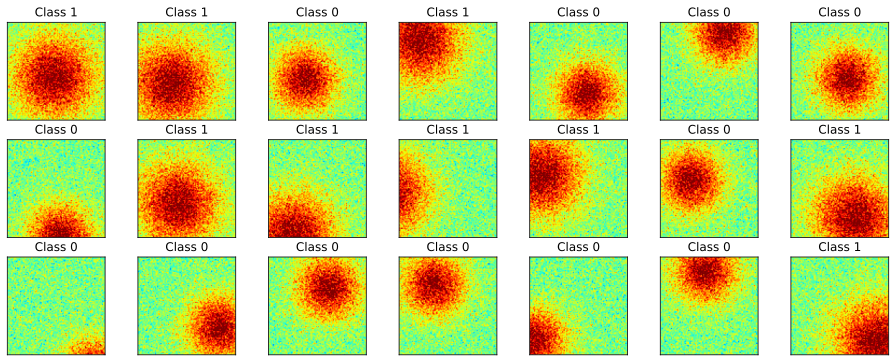

In [3]:
_, axis = plt.subplots(3, 7, figsize=(16, 6))

for i, ax in enumerate(axis.flatten()):
    pic = np.random.randint(2*num_per_class)
    gaussian = np.squeeze(images[pic, :, :])
    ax.imshow(gaussian, vmin=-1, vmax=1, cmap="jet")
    ax.set_title("Class %s"%int(labels[pic].item()))
    ax.set_xticks([])
    ax.set_yticks([])

plt.show()

In [4]:
train_data, test_data, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=17)

train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [5]:
def model():
    
    class CNN(nn.Module):
        def __init__(self):
            super().__init__()
            
            self.conv1 = nn.Conv2d(1, 6, 3, padding=1)
            
            self.conv2 = nn.Conv2d(6, 4, 3, padding=1)
            
            self.fc1 = nn.Linear(22*22*4, 50)
            
            self.out = nn.Linear(50, 1)
        
        def forward(self, x):
            x = self.conv1(x)
            conv1_act = f.relu(x)
            x = f.avg_pool2d(conv1_act, (2, 2))
            
            x = self.conv2(x)
            conv2_act = f.relu(x)
            x = f.avg_pool2d(conv2_act, (2, 2))
            
            x = x.reshape(x.shape[0], -1)
            
            x = self.fc1(x)
            x = f.relu(x)
            
            x = self.out(x)
            return x, conv1_act, conv2_act
    
    cnn = CNN()
    
    loss_fun = nn.BCEWithLogitsLoss()
    
    optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
    
    return cnn, loss_fun, optimizer

In [6]:
def train_model():
    
    num_epochs = 10

    cnn, loss_fun, optimizer = model()
    
    train_loss = []
    test_loss = []
    train_acc = []
    test_acc = []
    
    for epoch in range(num_epochs):
        
        batch_loss = []
        batch_acc = []
        
        for x, y in train_loader:
            y_hat = cnn(x)[0]
            
            loss = loss_fun(y_hat, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            batch_loss.append(loss.item())
            
            batch_acc.append(100*torch.mean(((y_hat > 0.5) == y).float()).item())
            
        train_loss.append(np.mean(batch_loss))
        train_acc.append(np.mean(batch_acc))
        
        x, y = next(iter(test_loader))
        
        with torch.no_grad():
            y_hat = cnn(x)[0]
            loss = loss_fun(y_hat, y)
            
        test_loss.append(loss.item())
        test_acc.append(100*torch.mean(((y_hat > 0.5) == y).float()).item())
        
    return train_loss, test_loss, train_acc, test_acc, cnn

In [7]:
train_loss, test_loss, train_acc, test_acc, cnn = train_model()

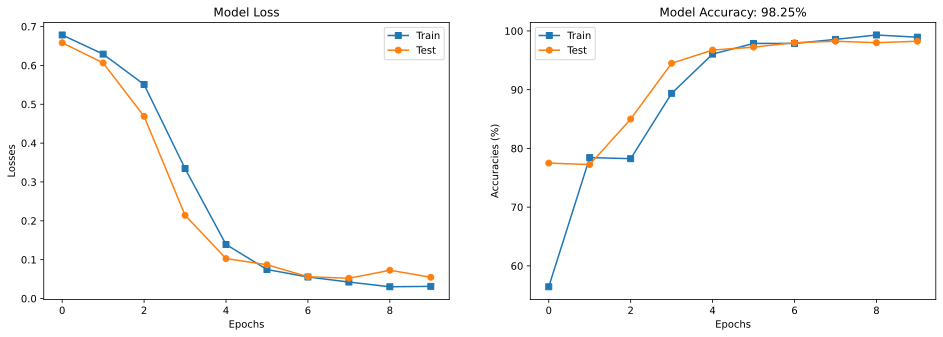

In [8]:
_, axis = plt.subplots(1, 2, figsize=(16, 5))

axis[0].plot(train_loss, 's-', label="Train")
axis[0].plot(test_loss, 'o-', label="Test")
axis[0].set_ylabel("Losses")
axis[0].set_xlabel("Epochs")
axis[0].set_title("Model Loss")
axis[0].legend()

axis[1].plot(train_acc, 's-', label="Train")
axis[1].plot(test_acc, 'o-', label="Test")
axis[1].set_ylabel("Accuracies (%)")
axis[1].set_xlabel("Epochs")
axis[1].set_title(f"Model Accuracy: {test_acc[-1]:0.2f}%")
axis[1].legend();

In [9]:
x, y = next(iter(test_loader))
y_hat, feature_map_1, feature_map_2 = cnn(x)

_, axis = plt.subplots(7, 10, figsize=(13, 9))

for pic_ind in range(10):
    img = x[pic_ind, 0, :, :].detach()
    axis[0, pic_ind].imshow(img, cmap="jet", vmin=0, vmax=1)
    axis[0, pic_ind].axis("off")
    axis[0, pic_ind].text(2, 2, "T:%s"%int(y[pic_ind].item()), ha="left", va="top", color="w", fontweight="bold")
    
    for feat_ind in range(6):
        img = feature_map_1[pic_ind, feat_ind, :, :].detach()
        axis[feat_ind+1, pic_ind].imshow(img, cmap="inferno", vmin=0, vmax=torch.max(img)*0.9)
        axis[feat_ind+1, pic_ind].axis("off")
        axis[feat_ind+1, pic_ind].text(-5, 45, feat_ind, ha="right") if pic_ind==0 else None
    
plt.tight_layout()
plt.suptitle("First set of feature map activations for 10 Test Images", x=0.5, y=1.01);

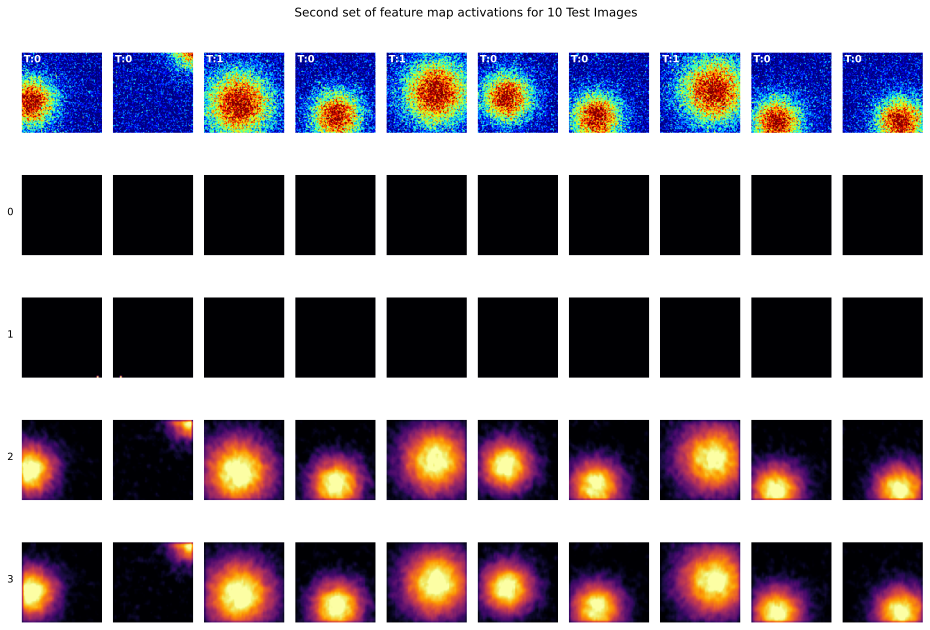

In [10]:
_, axis = plt.subplots(5, 10, figsize=(13, 9))

for pic_ind in range(10):
    img = x[pic_ind, 0, :, :].detach()
    axis[0, pic_ind].imshow(img, cmap="jet", vmin=0, vmax=1)
    axis[0, pic_ind].axis("off")
    axis[0, pic_ind].text(2, 2, "T:%s"%int(y[pic_ind].item()), ha="left", va="top", color="w", fontweight="bold")

    for feat_ind in range(4):
        img = feature_map_2[pic_ind, feat_ind, :, :].detach()
        axis[feat_ind+1, pic_ind].imshow(img, cmap="inferno", vmin=0, vmax=torch.max(img)*0.9)
        axis[feat_ind+1, pic_ind].axis("off")
        axis[feat_ind+1, pic_ind].text(-5, 22, feat_ind, ha="right") if pic_ind==0 else None

plt.tight_layout()
plt.suptitle("Second set of feature map activations for 10 Test Images", x=0.5, y=1.01);